## Test Predizione Traiettoria Navi LNN (senza nessun attacco)

In [1]:
import os

os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import polars as pl
import sys

from ncps.tf import CfC
from ncps.wirings import AutoNCP
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, TimeDistributed, RepeatVector
from tensorflow.keras import mixed_precision

import gc
from collections import Counter
import pyarrow.parquet as pq
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import iqr
from sklearn.metrics import mean_absolute_error, roc_curve, auc

# Configurazione GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# COSTANTI
WINDOW_SIZE = 30
BATCH_SIZE = 2048
COLONNE_FEATURES = ['Latitude', 'Longitude', 'SOG', 'COG']
INPUT_DIR = '../Pre-Elaborazione Dati/Dataset_Ready_For_AI_FINAL'
SCALER_PATH = 'scaler.joblib'
WEIGHTS_PATH = 'lnn_autoencoder_best.weights.h5'
LOG_PATH = 'training_log_lnn.csv'

# Parametri LNN
RECURRENT_UNITS = 128
BOTTLENECK_SIZE = 64

print("Configurazione completata.")

Configurazione completata.


In [2]:
if os.path.exists(SCALER_PATH):
    scaler = joblib.load(SCALER_PATH)
    print(f"Scaler caricato: {SCALER_PATH}")
else:
    raise FileNotFoundError("Errore: Scaler non trovato.")

all_files = sorted(glob.glob(os.path.join(INPUT_DIR, '*.parquet')))
TEST_FILES = all_files[20:24]

print(f"File totali trovati: {len(all_files)}")
print(f"File selezionati per il TEST: {len(TEST_FILES)}")
print(TEST_FILES)

Scaler caricato: scaler.joblib
File totali trovati: 25
File selezionati per il TEST: 4
['../Pre-Elaborazione Dati/Dataset_Ready_For_AI_FINAL/blocco_020-segmentato.parquet', '../Pre-Elaborazione Dati/Dataset_Ready_For_AI_FINAL/blocco_021-segmentato.parquet', '../Pre-Elaborazione Dati/Dataset_Ready_For_AI_FINAL/blocco_022-segmentato.parquet', '../Pre-Elaborazione Dati/Dataset_Ready_For_AI_FINAL/blocco_023-segmentato.parquet']


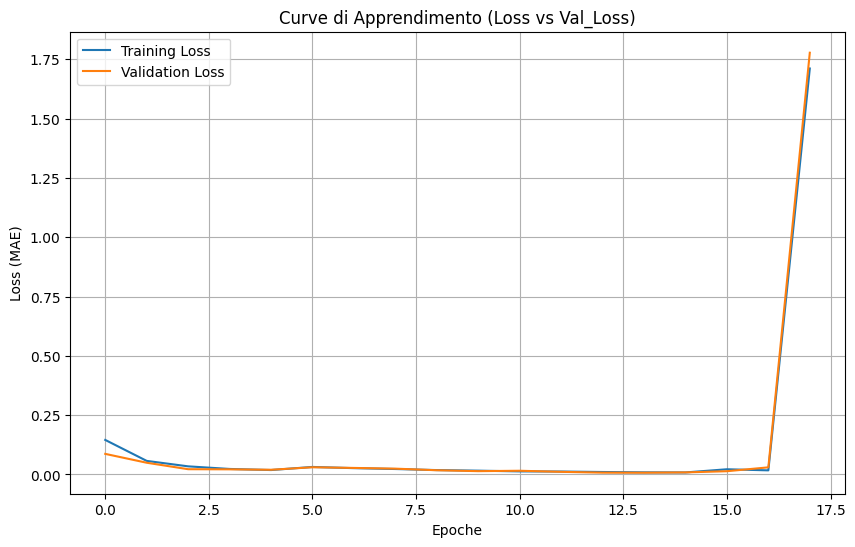

In [3]:
try:
    history = pd.read_csv(LOG_PATH)
    
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Curve di Apprendimento (Loss vs Val_Loss)')
    plt.xlabel('Epoche')
    plt.ylabel('Loss (MAE)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
except FileNotFoundError:
    print("File di log non trovato. Hai eseguito l'addestramento?")

In [4]:
def calculate_steps_per_epoch(file_paths, window_size, batch_size):
    """
    Scansiona tutti i file in modo efficiente (RAM-safe) per calcolare
    il numero totale di finestre (campioni) che verranno generate,
    e da lì calcola il numero di "steps" (batch) per epoca.
    Usa il metodo Counter.update(Series) che sappiamo funzionare.
    """
    print(f"Calcolo Steps per {len(file_paths)} file")
    
    total_lengths = Counter()
    
    #Trova le lunghezze di tutte le 4.3M traiettorie
    for i, file_path in enumerate(file_paths):
        print(f"  Scansione lunghezze file {i+1}/{len(file_paths)}...", end='\r')
        try:
            df = pd.read_parquet(file_path, columns=['TrajectoryID'])
            total_lengths.update(df['TrajectoryID'])
            del df
            gc.collect()
        except Exception as e:
            print(f"Errore nel leggere {file_path}: {e}")

    print("\nScansione completata.")

    #Calcola il numero totale di finestre
    total_windows = 0
    for length in total_lengths.values():
        if length >= window_size:
            total_windows += (length - window_size + 1)
            
    #Calcola gli steps
    steps = int(np.ceil(total_windows / batch_size))
    
    print(f"Trovate {total_windows:,} finestre totali.")
    print(f"Steps per Epoca (Batch Size {batch_size}): {steps}")
    print("-" * 75)
    return steps


def create_windows(data_np, window_size):
    windows = []
    for i in range(len(data_np) - window_size + 1):
        windows.append(data_np[i : i + window_size])
    return windows

def data_generator_v(file_paths, scaler, features, window_size, batch_size, shuffle_files=False):
    
    file_buffer = {} 
    window_buffer = [] 
    CHUNK_SIZE_ROWS = 500_000

    while True:
        if shuffle_files:
             # Shuffle disattivato forzatamente per garantire la sequenzialità
            shuffle_files = False 
            
        for file_path in file_paths:
            chunk_buffer = {}
            try:
                pf = pq.ParquetFile(file_path)
                for batch in pf.iter_batches(batch_size=CHUNK_SIZE_ROWS, columns=features + ['TrajectoryID']):
                    df_chunk = batch.to_pandas()
                    df_chunk[features] = scaler.transform(df_chunk[features])
                    next_chunk_buffer = {}
                    
                    for tid, group in df_chunk.groupby('TrajectoryID'):
                        if tid in chunk_buffer:
                            trajectory_data = pd.concat([chunk_buffer.pop(tid), group])
                        else:
                            trajectory_data = group
                        
                        if tid in file_buffer:
                            trajectory_data = pd.concat([file_buffer.pop(tid), trajectory_data])
                        
                        # Se la traiettoria tocca la fine del chunk, bufferizzala
                        if trajectory_data.iloc[-1].name == df_chunk.iloc[-1].name:
                            next_chunk_buffer[tid] = trajectory_data
                            continue 
                            
                        if len(trajectory_data) < window_size:
                            continue 
                            
                        trajectory_np = trajectory_data[features].to_numpy()
                        new_windows = create_windows(trajectory_np, window_size)
                        window_buffer.extend(new_windows)
                        
                        next_chunk_buffer[tid] = trajectory_data.iloc[-(window_size - 1):]

                        while len(window_buffer) >= batch_size:
                            batch_to_yield = window_buffer[:batch_size]
                            window_buffer = window_buffer[batch_size:]
                            yield (np.array(batch_to_yield), np.array(batch_to_yield))
                    
                    chunk_buffer = next_chunk_buffer
                file_buffer = chunk_buffer
            except Exception as e:
                print(f"\nErrore lettura {file_path}: {e}")
                continue
print("Funzioni definite")

Funzioni definite


In [5]:
n_features = len(COLONNE_FEATURES)

# Wiring
wiring = AutoNCP(RECURRENT_UNITS, output_size=BOTTLENECK_SIZE)

# Definizione Layer
inputs = Input(shape=(WINDOW_SIZE, n_features))
lnn_encoder = CfC(wiring, return_sequences=False, mixed_memory=True)(inputs)
repeat_vector = RepeatVector(WINDOW_SIZE)(lnn_encoder)
lnn_decoder = CfC(wiring, return_sequences=True, mixed_memory=True)(repeat_vector)
output = TimeDistributed(Dense(n_features))(lnn_decoder)

model = Model(inputs, output)

model.compile(optimizer='adam', loss='mae')

# Caricamento Pesi
if os.path.exists(WEIGHTS_PATH):
    print(f"Caricamento pesi da: {WEIGHTS_PATH}")
    model.load_weights(WEIGHTS_PATH)
    print("Modello LNN caricato e pronto.")
else:
    raise FileNotFoundError(f"File pesi non trovato: {WEIGHTS_PATH}")

I0000 00:00:1764680483.348420   46058 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4130 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Caricamento pesi da: lnn_autoencoder_best.weights.h5
Modello LNN caricato e pronto.


In [6]:
print("Calcolo step totali")
test_steps = calculate_steps_per_epoch(TEST_FILES, WINDOW_SIZE, BATCH_SIZE)
print(f"Steps totali per il test: {test_steps}")

# Generatore
test_gen = data_generator_v(
    file_paths=TEST_FILES,
    scaler=scaler,
    features=COLONNE_FEATURES,
    window_size=WINDOW_SIZE,
    batch_size=BATCH_SIZE,
    shuffle_files=False
)


Calcolo step totali
Calcolo Steps per 4 file
  Scansione lunghezze file 4/4...
Scansione completata.
Trovate 35,486,288 finestre totali.
Steps per Epoca (Batch Size 2048): 17328
---------------------------------------------------------------------------
Steps totali per il test: 17328


In [ ]:
print(f"\nAvvio Valutazione su {len(TEST_FILES)} file")
test_loss = model.evaluate(test_gen, steps=test_steps, verbose=1)

print("-" * 30)
print(f"RISULTATO FINALE LNN:")
print(f"Mean Absolute Error (MAE): {test_loss:.5f}")
print("-" * 30)

Calcolo step totali
Calcolo Steps per 4 file
  Scansione lunghezze file 4/4...
Scansione completata.
Trovate 35,486,288 finestre totali.
Steps per Epoca (Batch Size 2048): 17328
---------------------------------------------------------------------------
Steps totali per il test: 17328

Avvio Valutazione su 4 file
17328/17328 [==============================] - 519s 30ms/step - loss: 0.0079
------------------------------
RISULTATO FINALE LNN:
Mean Absolute Error (MAE): 0.00790
------------------------------


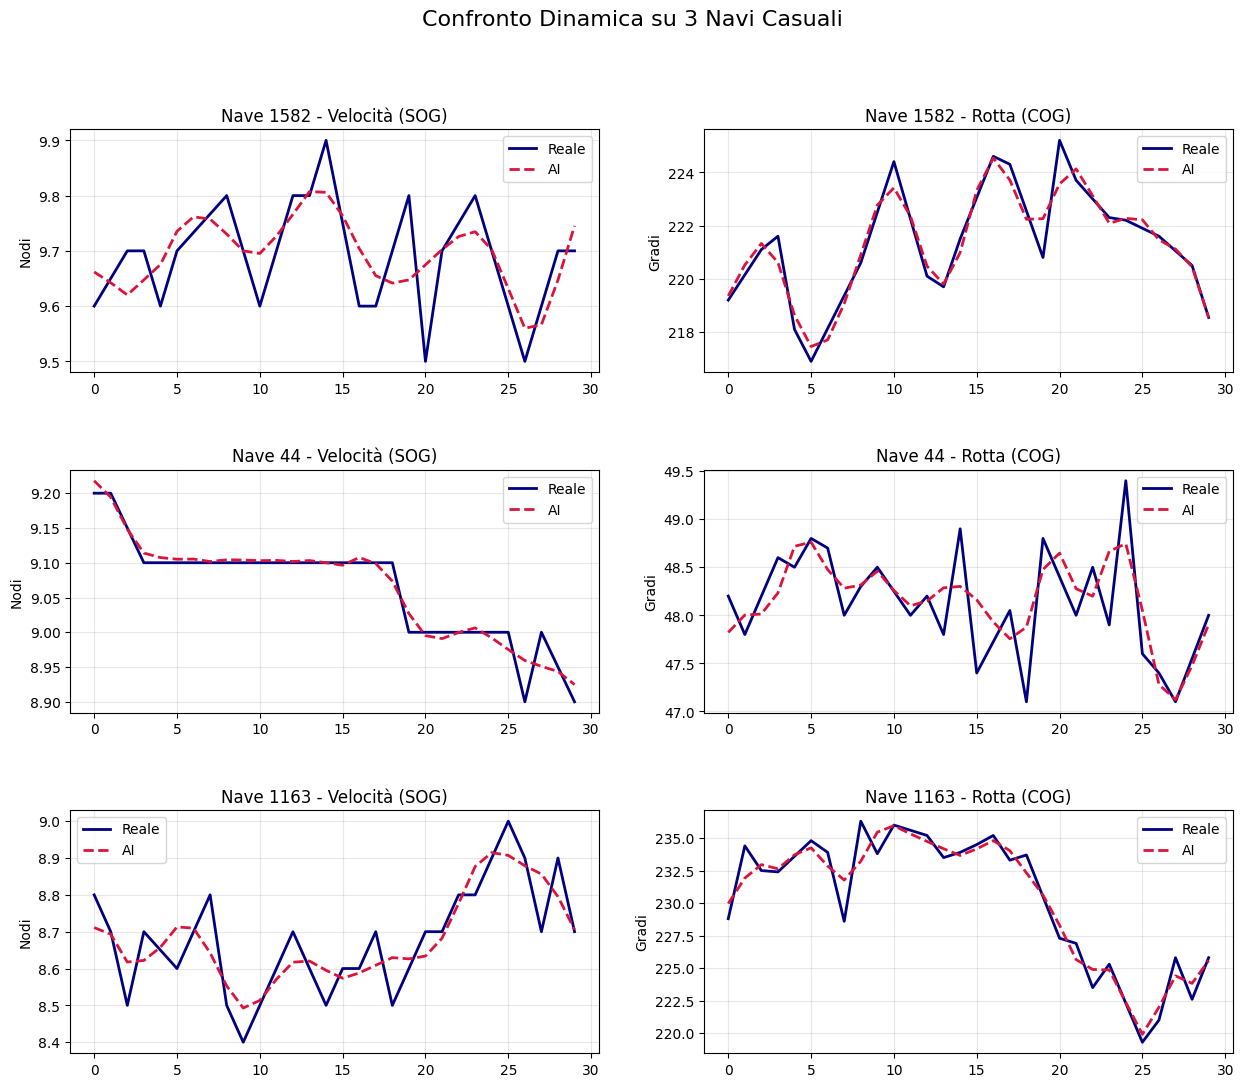

In [6]:
# Batch di dati
test_gen = data_generator_v(
    file_paths=TEST_FILES,
    scaler=scaler,
    features=COLONNE_FEATURES,
    window_size=WINDOW_SIZE,
    batch_size=BATCH_SIZE,
    shuffle_files=False
)

X_batch, _ = next(test_gen)
pred_batch = model.predict(X_batch, verbose=0)

# Denormalizza tutto subito (per avere nodi e gradi)
sh = X_batch.shape
X_real = scaler.inverse_transform(X_batch.reshape(-1, sh[2])).reshape(sh)
P_real = scaler.inverse_transform(pred_batch.reshape(-1, sh[2])).reshape(sh)

# Scegliamo 3 navi a caso dal batch da mostrare
num_esempi = 3
indices = random.sample(range(len(X_real)), num_esempi)

# Plot
fig, axes = plt.subplots(nrows=num_esempi, ncols=2, figsize=(15, 4 * num_esempi))
plt.subplots_adjust(hspace=0.4)

for i, idx in enumerate(indices):
    # Dati della nave corrente
    real = X_real[idx]
    pred = P_real[idx]
    
    # Colonna 1: Velocità (SOG) - Indice 2
    axes[i, 0].plot(real[:, 2], label='Reale', color='navy', linewidth=2)
    axes[i, 0].plot(pred[:, 2], label='AI', color='crimson', linestyle='--', linewidth=2)
    axes[i, 0].set_title(f"Nave {idx} - Velocità (SOG)")
    axes[i, 0].set_ylabel("Nodi")
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)
    
    # Colonna 2: Rotta (COG) - Indice 3
    axes[i, 1].plot(real[:, 3], label='Reale', color='navy', linewidth=2)
    axes[i, 1].plot(pred[:, 3], label='AI', color='crimson', linestyle='--', linewidth=2)
    axes[i, 1].set_title(f"Nave {idx} - Rotta (COG)")
    axes[i, 1].set_ylabel("Gradi")
    axes[i, 1].legend()
    axes[i, 1].grid(True, alpha=0.3)

plt.suptitle(f"Confronto Dinamica su {num_esempi} Navi Casuali", fontsize=16)
plt.show()

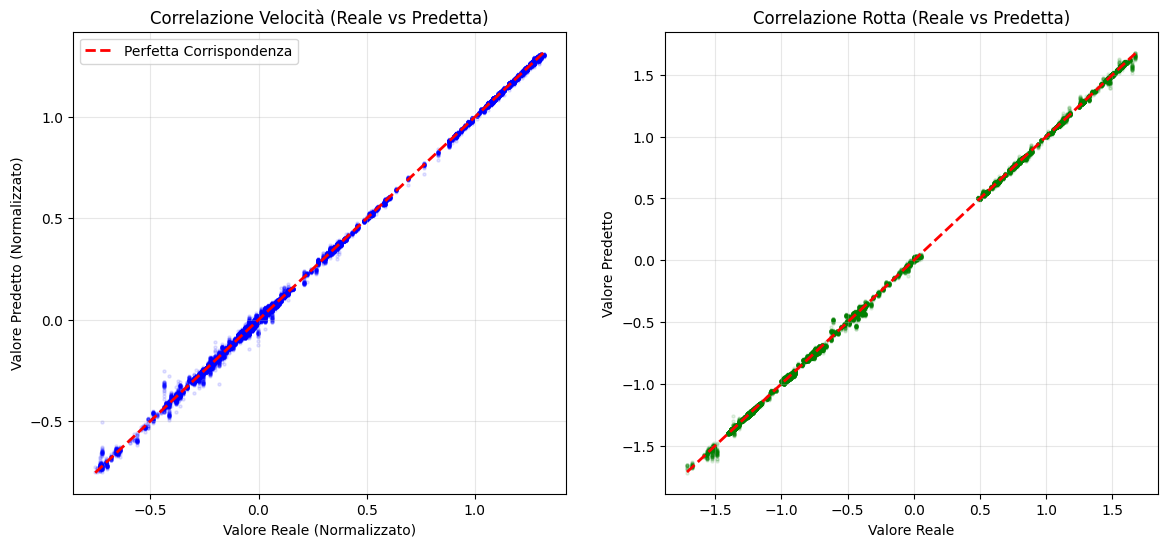

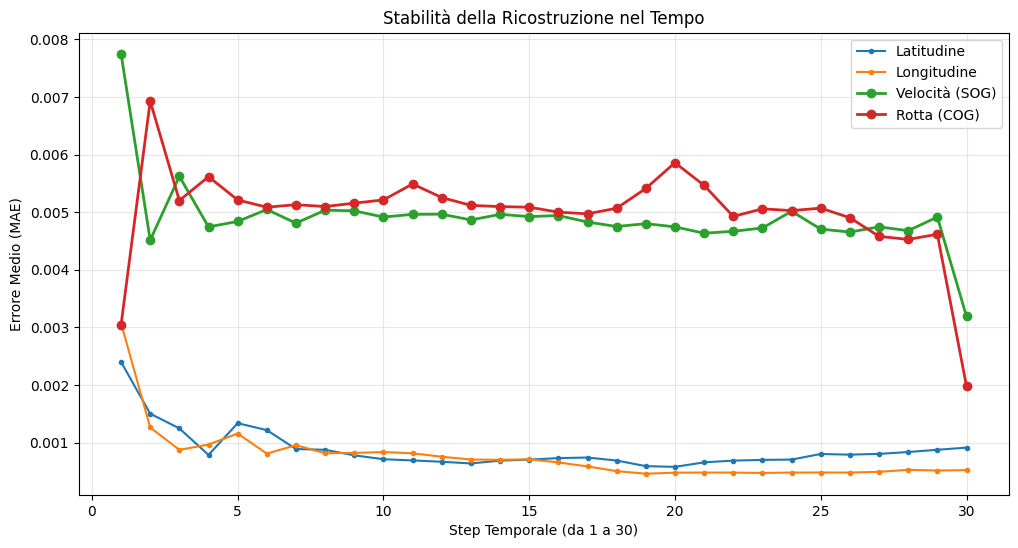

In [7]:
X_test_batch, _ = next(test_gen)
X_pred_batch = model.predict(X_test_batch, verbose=0)

plt.figure(figsize=(14, 6))

# Plot per la Velocità (SOG)
plt.subplot(1, 2, 1)

y_true = X_test_batch[:, :, 2].flatten() # Indice 2 = SOG
y_pred = X_pred_batch[:, :, 2].flatten()

plt.scatter(y_true, y_pred, alpha=0.1, s=5, color='blue')
# Disegniamo la diagonale perfetta (Idealmente y=x)
min_val, max_val = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfetta Corrispondenza')

plt.title("Correlazione Velocità (Reale vs Predetta)")
plt.xlabel("Valore Reale (Normalizzato)")
plt.ylabel("Valore Predetto (Normalizzato)")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot per la Rotta (COG)
plt.subplot(1, 2, 2)
y_true_cog = X_test_batch[:, :, 3].flatten() # Indice 3 = COG
y_pred_cog = X_pred_batch[:, :, 3].flatten()

plt.scatter(y_true_cog, y_pred_cog, alpha=0.1, s=5, color='green')
plt.plot([min(y_true_cog), max(y_true_cog)], [min(y_true_cog), max(y_true_cog)], 'r--', linewidth=2)

plt.title("Correlazione Rotta (Reale vs Predetta)")
plt.xlabel("Valore Reale")
plt.ylabel("Valore Predetto")
plt.grid(True, alpha=0.3)

plt.show()


mae_per_step = np.mean(np.abs(X_test_batch - X_pred_batch), axis=0)

plt.figure(figsize=(12, 6))
steps = range(1, WINDOW_SIZE + 1)

plt.plot(steps, mae_per_step[:, 0], label='Latitudine', marker='.')
plt.plot(steps, mae_per_step[:, 1], label='Longitudine', marker='.')
plt.plot(steps, mae_per_step[:, 2], label='Velocità (SOG)', marker='o', linewidth=2)
plt.plot(steps, mae_per_step[:, 3], label='Rotta (COG)', marker='o', linewidth=2)

plt.title("Stabilità della Ricostruzione nel Tempo")
plt.xlabel("Step Temporale (da 1 a 30)")
plt.ylabel("Errore Medio (MAE)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

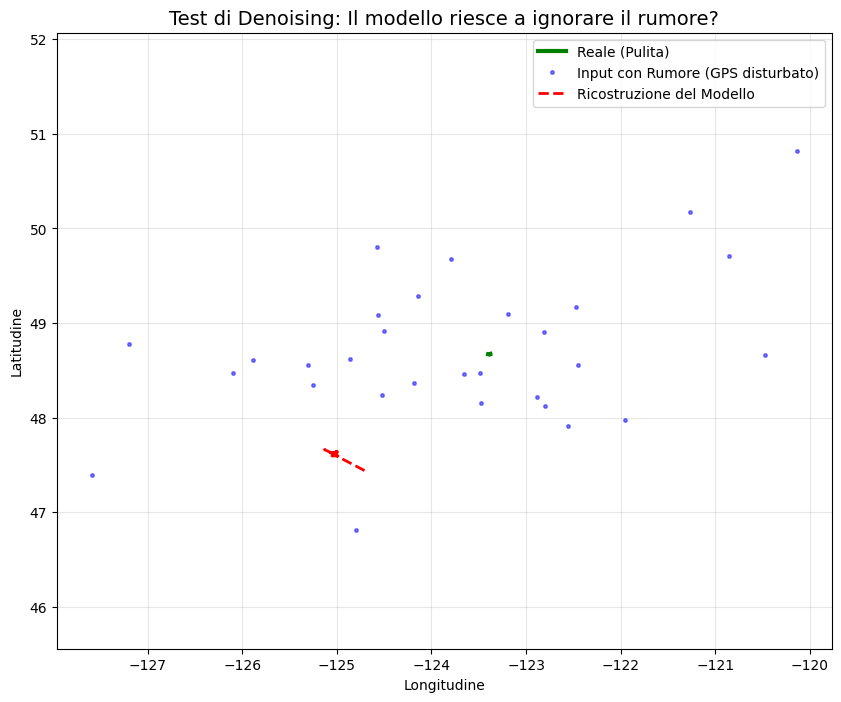

In [23]:
encoder_model = Model(inputs=model.input, outputs=model.layers[1].output)

X_batch_latent, _ = next(test_gen) 
for _ in range(100): # Accumuliamo circa 100 campioni
    b, _ = next(test_gen)
    X_batch_latent = np.concatenate([X_batch_latent, b])


# Prendiamo una traiettoria pulita
idx_robust = 0
clean_traj = X_batch_latent[idx_robust]

# Aggiungiamo rumore artificiale
noise = np.random.normal(0, 0.1, clean_traj.shape) # Rumore gaussiano
noisy_traj = clean_traj + noise

# Chiediamo al modello di ricostruire quella RUMOROSA
# (Nota: il modello non ha mai visto questo rumore in addestramento!)
pred_from_noisy = model.predict(noisy_traj.reshape(1, WINDOW_SIZE, 4), verbose=0)[0]

clean_phys = scaler.inverse_transform(clean_traj)
noisy_phys = scaler.inverse_transform(noisy_traj)
pred_phys = scaler.inverse_transform(pred_from_noisy)

plt.figure(figsize=(10, 8))
plt.plot(clean_phys[:, 1], clean_phys[:, 0], 'g-', linewidth=3, label='Reale (Pulita)')
plt.plot(noisy_phys[:, 1], noisy_phys[:, 0], 'b.', markersize=5, alpha=0.5, label='Input con Rumore (GPS disturbato)')
plt.plot(pred_phys[:, 1], pred_phys[:, 0], 'r--', linewidth=2, label='Ricostruzione del Modello')

plt.title("Test di Denoising: Il modello riesce a ignorare il rumore?", fontsize=14)
plt.xlabel("Longitudine")
plt.ylabel("Latitudine")
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
import sys

print("AVVIO CALIBRAZIONE DOPPIA SOGLIA")
scores_dyn_list = []
scores_phys_list = []
count = 0

# Loop sul 10% test set
for i in range(test_steps // 10): 
    try:
        X_b, _ = next(test_gen)
    except StopIteration:
        break
        
    # Calcolo Scores
    s_dyn, s_phys = calculate_dual_scores(X_b, model, scaler)
    
    scores_dyn_list.extend(s_dyn)
    scores_phys_list.extend(s_phys)
    
    count += len(X_b)
    print(f"Processati {count} campioni...", end='\r')

# Conversione in array
scores_dyn = np.array(scores_dyn_list)
scores_phys = np.array(scores_phys_list)

# Calcolo Soglie (Mean + 3*Std)
thresh_dyn = np.mean(scores_dyn) + 3 * np.std(scores_dyn)
thresh_phys = np.mean(scores_phys) + 3 * np.std(scores_phys)

print(f"\n\nCALIBRAZIONE COMPLETATA.")
print("-" * 40)
print(f"1. SOGLIA DINAMICA (SOG/COG):  {thresh_dyn:.6f}")
print(f"   (Rileva manovre impossibili o spoofing velocità)")
print("-" * 40)
print(f"2. SOGLIA FISICA (Lat/Lon):    {thresh_phys:.6f} (Miglia Nautiche)")
print(f"   (Rileva teletrasporti o spoofing posizione)")
print("-" * 40)

AVVIO CALIBRAZIONE DOPPIA SOGLIA
Processati 3547136 campioni...

CALIBRAZIONE COMPLETATA.
----------------------------------------
1. SOGLIA DINAMICA (SOG/COG):  0.081821
   (Rileva manovre impossibili o spoofing velocità)
----------------------------------------
2. SOGLIA FISICA (Lat/Lon):    6.934675 (Miglia Nautiche)
   (Rileva teletrasporti o spoofing posizione)
----------------------------------------


📊 RICALIBRAZIONE RAPIDA SOGLIE (su batch pulito)...
   • Nuova Soglia Dinamica: 0.0933
   • Nuova Soglia Fisica:   0.0711

⚔️ AVVIO SIMULAZIONE ATTACCHI (VERSIONE 2.0)...

🛡️ RISULTATO FINALE
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1024
      Attack       1.00      1.00      1.00      1024

    accuracy                           1.00      2048
   macro avg       1.00      1.00      1.00      2048
weighted avg       1.00      1.00      1.00      2048


🔍 DETTAGLIO CATTURE:
1. Speed Spoofing: 341/341
2. Teleport:       341/341
3. Ghost Ship:     342/342


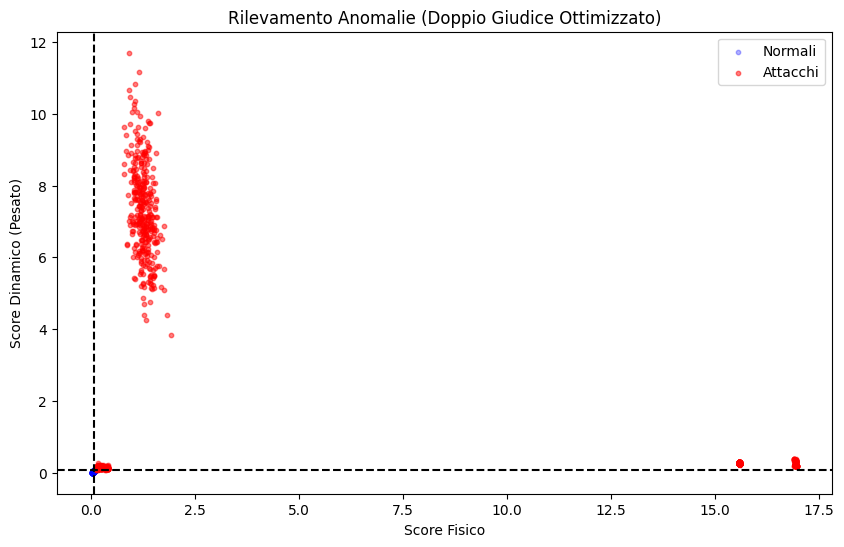

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. FUNZIONI DI SUPPORTO (FISICA E CALCOLO SCORE) ---

def physics_reconstruction(X_real_scaled, P_pred_scaled, scaler):
    """
    Ricostruisce la posizione usando SOG/COG predetti dalla rete
    applicati al punto di partenza reale.
    """
    b, w, f = X_real_scaled.shape
    
    # Denormalizzazione
    X_phys = scaler.inverse_transform(X_real_scaled.reshape(-1, f)).reshape(b, w, f)
    P_phys = scaler.inverse_transform(P_pred_scaled.reshape(-1, f)).reshape(b, w, f)
    
    # Estrazione Variabili (0:Lat, 1:Lon, 2:SOG, 3:COG)
    lat_prev = X_phys[:, :-1, 0]
    lon_prev = X_phys[:, :-1, 1]
    sog_pred = P_phys[:, :-1, 2]
    cog_pred = P_phys[:, :-1, 3]
    
    # Fisica (Dead Reckoning)
    dt = 1.0 / 60.0 # 1 minuto in ore
    cog_rad = np.radians(cog_pred)
    dist_nm = sog_pred * dt
    
    delta_lat = (dist_nm * np.cos(cog_rad)) / 60.0
    avg_lat_rad = np.radians(lat_prev)
    delta_lon = (dist_nm * np.sin(cog_rad)) / (60.0 * np.cos(avg_lat_rad))
    
    lat_calc = lat_prev + delta_lat
    lon_calc = lon_prev + delta_lon
    
    # Target Reale (t)
    lat_true = X_phys[:, 1:, 0]
    lon_true = X_phys[:, 1:, 1]
    
    return lat_true, lon_true, lat_calc, lon_calc, P_phys, X_phys

def calculate_optimized_scores(X_batch, model, scaler):
    """
    Calcola score dinamico (pesato) e fisico.
    """
    # Inferenza
    P_batch = model.predict(X_batch, verbose=0)
    
    # Ricostruzione Fisica e Denormalizzazione
    lat_t, lon_t, lat_c, lon_c, P_phys, X_phys = physics_reconstruction(X_batch, P_batch, scaler)
    
    # --- SCORE DINAMICO (Migliorato) ---
    sog_real = X_phys[:, 1:, 2]
    sog_pred = P_phys[:, 1:, 2]
    cog_real = X_phys[:, 1:, 3]
    cog_pred = P_phys[:, 1:, 3]
    
    diff_sog = np.abs(sog_real - sog_pred)
    
    # Errore Angolare COG (gestione 360)
    diff_cog = np.abs(cog_real - cog_pred)
    diff_cog = np.minimum(diff_cog, 360 - diff_cog)
    
    # NUOVI PESI (Tuning per beccare Ghost e Speed)
    # Diamo più peso agli errori per renderli visibili
    w_sog = 1.0 / 5.0   # Più sensibile alla velocità (era 1/30)
    w_cog = 1.0 / 45.0  # Molto più sensibile alla rotta (era 1/180)
    
    score_dyn = np.mean((diff_sog * w_sog) + (diff_cog * w_cog), axis=1)

    # --- SCORE FISICO ---
    err_lat = (lat_t - lat_c) * 60.0
    err_lon = (lon_t - lon_c) * 60.0 * np.cos(np.radians(lat_t))
    dist_error = np.sqrt(err_lat**2 + err_lon**2)
    
    score_phys = np.mean(dist_error, axis=1)
    
    return score_dyn, score_phys


# --- 2. RICALIBRAZIONE SOGLIE (Necessaria con la nuova formula) ---

print("📊 RICALIBRAZIONE RAPIDA SOGLIE (su batch pulito)...")
# Usiamo un subset pulito per definire cosa è "normale" con la nuova formula
# (Per brevità usiamo 10 batch, in produzione useresti tutto il val set)
calib_scores_dyn = []
calib_scores_phys = []

# Ricreiamo generatore per sicurezza
try:
    # Assicurati che data_generator_v sia disponibile
    test_gen = data_generator_v(TEST_FILES, scaler, COLONNE_FEATURES, WINDOW_SIZE, BATCH_SIZE)
except NameError:
    print("⚠️ Attenzione: Assicurati di aver eseguito la cella con la definizione di data_generator_v")

for _ in range(5): # 5 batch di calibrazione (~10k campioni)
    X_calib, _ = next(test_gen)
    s_d, s_p = calculate_optimized_scores(X_calib, model, scaler)
    calib_scores_dyn.extend(s_d)
    calib_scores_phys.extend(s_p)

# Calcolo Nuove Soglie (Mean + 3*Std)
thresh_dyn_new = np.mean(calib_scores_dyn) + 3 * np.std(calib_scores_dyn)
thresh_phys_new = np.mean(calib_scores_phys) + 3 * np.std(calib_scores_phys)

print(f"   • Nuova Soglia Dinamica: {thresh_dyn_new:.4f}")
print(f"   • Nuova Soglia Fisica:   {thresh_phys_new:.4f}")


# --- 3. SIMULAZIONE ATTACCHI (Migliorata) ---

print("\n⚔️ AVVIO SIMULAZIONE ATTACCHI (VERSIONE 2.0)...")

# Prendiamo un nuovo batch pulito
X_clean, _ = next(test_gen)
n_samples = len(X_clean)
n_attacks = n_samples // 2

X_test_mixed = X_clean.copy()
y_true_labels = np.zeros(n_samples)

# Indici
n_split = n_attacks // 3
idx_speed = range(0, n_split)
idx_teleport = range(n_split, 2 * n_split)
idx_ghost = range(2 * n_split, n_attacks)

# A. Speed Spoofing (MIGLIORATO: Rumore/Scatti invece di valore fisso)
# Aggiungiamo rumore forte alla velocità per rompere la coerenza temporale
noise_speed = np.random.normal(10.0, 5.0, X_test_mixed[idx_speed, :, 2].shape) 
X_test_mixed[idx_speed, :, 2] += noise_speed # Additivo invece che sostitutivo
y_true_labels[idx_speed] = 1

# B. Teleport (Come prima, funziona bene)
X_test_mixed[idx_teleport, -1, 0] += 0.5 
X_test_mixed[idx_teleport, -1, 1] += 0.5
y_true_labels[idx_teleport] = 1

# C. Ghost Ship (MIGLIORATO: Inversione + Rumore)
# Invertiamo la rotta E aggiungiamo jitter
X_test_mixed[idx_ghost, :, 3] = (X_test_mixed[idx_ghost, :, 3] + 0.5) % 1.0 # Shift 180 gradi (normalizzato 0-1)
X_test_mixed[idx_ghost, :, 3] += np.random.normal(0, 0.1, X_test_mixed[idx_ghost, :, 3].shape)
y_true_labels[idx_ghost] = 1


# --- 4. RILEVAMENTO E REPORT ---

# Calcolo scores sul dataset misto
scores_dyn_test, scores_phys_test = calculate_optimized_scores(X_test_mixed, model, scaler)

# Applicazione Soglie
y_pred = (scores_dyn_test > thresh_dyn_new) | (scores_phys_test > thresh_phys_new)
y_pred = y_pred.astype(int)

# Analisi
cm = confusion_matrix(y_true_labels, y_pred)

print("\n" + "="*60)
print("🛡️ RISULTATO FINALE")
print("="*60)
print(classification_report(y_true_labels, y_pred, target_names=['Normal', 'Attack']))

# Dettaglio per tipo
mask_speed = np.zeros(n_samples, dtype=bool); mask_speed[idx_speed] = True
mask_tele = np.zeros(n_samples, dtype=bool); mask_tele[idx_teleport] = True
mask_ghost = np.zeros(n_samples, dtype=bool); mask_ghost[idx_ghost] = True

print("\n🔍 DETTAGLIO CATTURE:")
print(f"1. Speed Spoofing: {np.sum(y_pred[mask_speed])}/{np.sum(mask_speed)}")
print(f"2. Teleport:       {np.sum(y_pred[mask_tele])}/{np.sum(mask_tele)}")
print(f"3. Ghost Ship:     {np.sum(y_pred[mask_ghost])}/{np.sum(mask_ghost)}")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(scores_phys_test[y_true_labels==0], scores_dyn_test[y_true_labels==0], c='blue', alpha=0.3, label='Normali', s=10)
plt.scatter(scores_phys_test[y_true_labels==1], scores_dyn_test[y_true_labels==1], c='red', alpha=0.5, label='Attacchi', s=10)
plt.axvline(x=thresh_phys_new, color='k', linestyle='--')
plt.axhline(y=thresh_dyn_new, color='k', linestyle='--')
plt.xlabel("Score Fisico"); plt.ylabel("Score Dinamico (Pesato)")
plt.title("Rilevamento Anomalie (Doppio Giudice Ottimizzato)")
plt.legend()
plt.show()

⚔️ AVVIO TEST MASSIVO (Versione 3.0 - Silent Drift Included)...
   • Caricamento di 100 batch dal Test Set...
   • Totale Navi nel Test: 204,800
   • Iniezione vettori di attacco...
   • Elaborazione Neurale e Fisica in corso...

🛡️ REPORT FINALE (Su 204800 Navi)
Performance Globali:
   • Accuracy:  0.9891
   • Precision: 0.9916 (Affidabilità allarme)
   • Recall:    0.9948 (Capacità rilevamento)

🔍 DETTAGLIO PER TIPO DI ATTACCO:
--------------------------------------------------
TIPO ATTACCO         | RILEVATI   | TOTALE     | RATE      
--------------------------------------------------
1. Speed Spoofing    | 40960      | 40960      | 100.0%
2. Teleport (GPS)    | 40960      | 40960      | 100.0%
3. Ghost Ship (COG)  | 40108      | 40960      | 97.9%
4. Silent Drift      | 40960      | 40960      | 100.0%
--------------------------------------------------
*. Traffico Normale  | 1382       | 40960      | 3.4%
(Nota: Per 'Normale', il Rate indica i Falsi Positivi, deve essere basso)


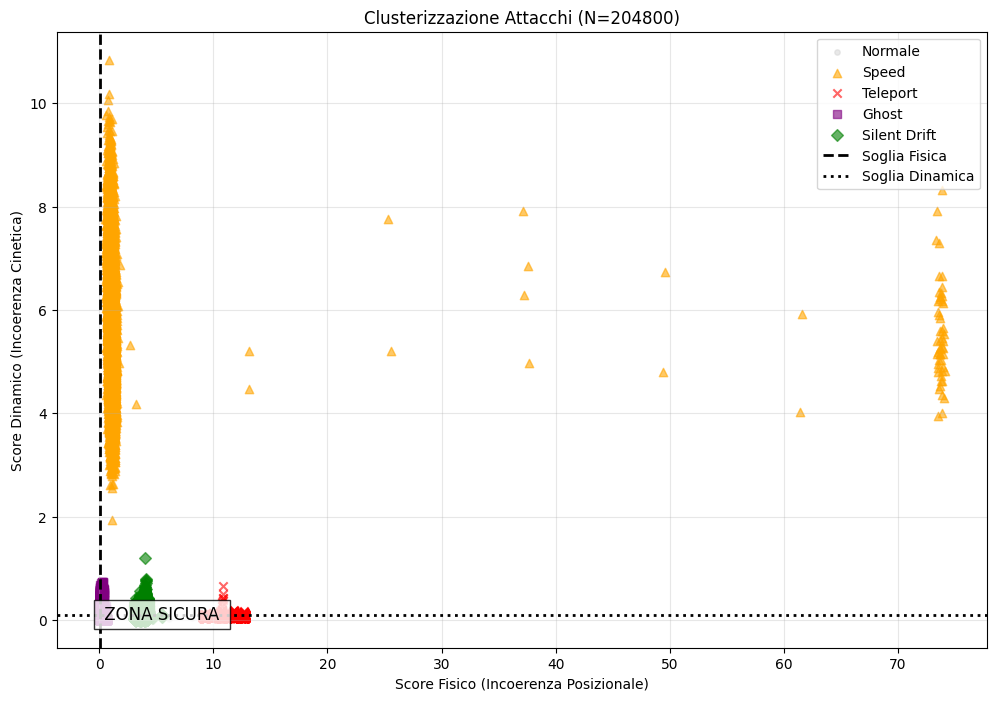

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# --- CONFIGURAZIONE ---
# Usa le soglie che hai calibrato prima!
THRESH_DYN = 0.0933  
THRESH_PHYS = 0.0711

# Numero di Batch da accumulare per il test (Più campioni!)
NUM_BATCHES_TEST = 100

print(f"⚔️ AVVIO TEST MASSIVO (Versione 3.0 - Silent Drift Included)...")

# 1. ACCUMULO DATI (10.000+ Campioni)
X_list = []
print(f"   • Caricamento di {NUM_BATCHES_TEST} batch dal Test Set...")

try:
    for _ in range(NUM_BATCHES_TEST):
        batch, _ = next(test_gen)
        X_list.append(batch)
    X_large = np.concatenate(X_list, axis=0)
except StopIteration:
    # Se finisce il generatore, lo ricarichiamo
    print("   ! Generatore esaurito, ricarico...")
    test_gen = data_generator_v(TEST_FILES, scaler, COLONNE_FEATURES, WINDOW_SIZE, BATCH_SIZE)
    batch, _ = next(test_gen)
    X_large = batch # Fallback su 1 batch se siamo alla fine

n_samples = len(X_large)
print(f"   • Totale Navi nel Test: {n_samples:,}")

# 2. INIEZIONE ATTACCHI (4 Tipologie)
# Dividiamo il set in 5 parti: 1 Normale + 4 Attacchi
n_cats = 5 
split_size = n_samples // n_cats

X_test_mixed = X_large.copy()
y_true_labels = np.zeros(n_samples)   # 0 = Normale
attack_types = np.zeros(n_samples)    # Per analisi dettagliata

# Definiamo gli intervalli
idx_norm = range(0, split_size)
idx_speed = range(split_size, 2*split_size)
idx_tele = range(2*split_size, 3*split_size)
idx_ghost = range(3*split_size, 4*split_size)
idx_drift = range(4*split_size, n_samples) # Il nuovo attacco

print("   • Iniezione vettori di attacco...")

# A. Speed Spoofing (Rumore forte su SOG)
noise_speed = np.random.normal(8.0, 4.0, X_test_mixed[idx_speed, :, 2].shape) 
X_test_mixed[idx_speed, :, 2] += noise_speed
y_true_labels[idx_speed] = 1
attack_types[idx_speed] = 1

# B. Teleport (Salto improvviso posizione finale)
X_test_mixed[idx_tele, -5:, 0] += 0.3 # Salto negli ultimi 5 minuti
X_test_mixed[idx_tele, -5:, 1] += 0.3
y_true_labels[idx_tele] = 1
attack_types[idx_tele] = 2

# C. Ghost Ship (Inversione Rotta + Jitter)
X_test_mixed[idx_ghost, :, 3] = (X_test_mixed[idx_ghost, :, 3] + 0.5) % 1.0 
y_true_labels[idx_ghost] = 1
attack_types[idx_ghost] = 3

# D. SILENT DRIFT (Nuovo!)
# Deviazione che cresce linearmente nel tempo (come una corrente che ti sposta)
# Creiamo una rampa da 0 a 0.05 (normalizzato) lungo la finestra di 30 minuti
drift_ramp = np.linspace(0, 0.1, WINDOW_SIZE) 
# Applichiamo la rampa alla Latitudine e Longitudine per tutte le navi nel gruppo drift
for i in idx_drift:
    X_test_mixed[i, :, 0] += drift_ramp # Drift su Lat
    X_test_mixed[i, :, 1] += drift_ramp # Drift su Lon

y_true_labels[idx_drift] = 1
attack_types[idx_drift] = 4


# 3. ESECUZIONE SISTEMA DI DIFESA
print("   • Elaborazione Neurale e Fisica in corso...")

# Inferenza su tutto il dataset massivo
# Nota: predict gestisce internamente il batching, quindi la RAM non esplode
scores_dyn, scores_phys = calculate_optimized_scores(X_test_mixed, model, scaler)

# Applicazione Soglie
y_pred = (scores_dyn > THRESH_DYN) | (scores_phys > THRESH_PHYS)
y_pred = y_pred.astype(int)

# 4. REPORT AVANZATO
print("\n" + "="*60)
print(f"🛡️ REPORT FINALE (Su {n_samples} Navi)")
print("="*60)

# Matrice di Confusione
cm = confusion_matrix(y_true_labels, y_pred)
accuracy = np.trace(cm) / np.sum(cm)
precision = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1]+cm[0,1]) > 0 else 0
recall = cm[1,1] / (cm[1,0] + cm[1,1])

print(f"Performance Globali:")
print(f"   • Accuracy:  {accuracy:.4f}")
print(f"   • Precision: {precision:.4f} (Affidabilità allarme)")
print(f"   • Recall:    {recall:.4f} (Capacità rilevamento)")

print("\n🔍 DETTAGLIO PER TIPO DI ATTACCO:")
print("-" * 50)
print(f"{'TIPO ATTACCO':<20} | {'RILEVATI':<10} | {'TOTALE':<10} | {'RATE':<10}")
print("-" * 50)

# Funzione helper per stampare righe
def print_stat(name, idx_range):
    caught = np.sum(y_pred[idx_range])
    tot = len(idx_range)
    rate = (caught/tot)*100
    print(f"{name:<20} | {caught:<10} | {tot:<10} | {rate:.1f}%")

print_stat("1. Speed Spoofing", idx_speed)
print_stat("2. Teleport (GPS)", idx_tele)
print_stat("3. Ghost Ship (COG)", idx_ghost)
print_stat("4. Silent Drift", idx_drift)
print("-" * 50)
print_stat("*. Traffico Normale", idx_norm) 
print("(Nota: Per 'Normale', il Rate indica i Falsi Positivi, deve essere basso)")


# 5. GRAFICO A 4 QUADRANTI
plt.figure(figsize=(12, 8))

# Plot Normale
plt.scatter(scores_phys[idx_norm], scores_dyn[idx_norm], c='lightgrey', alpha=0.5, label='Normale', s=15)

# Plot Attacchi
plt.scatter(scores_phys[idx_speed], scores_dyn[idx_speed], c='orange', marker='^', label='Speed', alpha=0.6)
plt.scatter(scores_phys[idx_tele], scores_dyn[idx_tele], c='red', marker='x', label='Teleport', alpha=0.6)
plt.scatter(scores_phys[idx_ghost], scores_dyn[idx_ghost], c='purple', marker='s', label='Ghost', alpha=0.6)
plt.scatter(scores_phys[idx_drift], scores_dyn[idx_drift], c='green', marker='D', label='Silent Drift', alpha=0.6)

# Linee Soglia
plt.axvline(x=THRESH_PHYS, color='black', linestyle='--', linewidth=2, label='Soglia Fisica')
plt.axhline(y=THRESH_DYN, color='black', linestyle=':', linewidth=2, label='Soglia Dinamica')

plt.xlabel('Score Fisico (Incoerenza Posizionale)')
plt.ylabel('Score Dinamico (Incoerenza Cinetica)')
plt.title(f'Clusterizzazione Attacchi (N={n_samples})')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Zona di Sicurezza
plt.text(0, 0, " ZONA SICURA ", bbox=dict(facecolor='white', alpha=0.8), fontsize=12)

plt.show()